Lets clone our repository initially

In [1]:
!git clone   https://github.com/chel310/Trash_classifier.git 
%cd Trash_classifier/


Cloning into 'Trash_classifier'...
remote: Enumerating objects: 28888, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 28888 (delta 51), reused 44 (delta 11), pack-reused 28760
Receiving objects: 100% (28888/28888), 946.14 MiB | 17.50 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Updating files: 100% (16732/16732), done.
/content/Trash_classifier


In [1]:
!pip freeze 


absl-py==1.4.0
albumentations==1.3.0
apt-xapian-index==0.49
asgiref==3.6.0
asttokens==2.2.1
astunparse==1.6.3
backcall==0.2.0
blinker==1.6.2
cachetools==5.3.0
certifi==2022.12.7
chardet==4.0.0
charset-normalizer==3.1.0
click==8.1.3
cmake==3.26.3
colorama==0.4.4
comm==0.1.3
command-not-found==0.3
contourpy==1.0.7
cryptography==3.4.8
cupshelpers==1.0
cycler==0.11.0
dbus-python==1.2.18
debugpy==1.6.7
decorator==5.1.1
distro==1.7.0
distro-info===1.1build1
Django==4.2
executing==1.2.0
filelock==3.12.0
Flask==2.3.2
flatbuffers==23.5.8
fonttools==4.39.3
fuse-python==1.0.2
gast==0.4.0
google-auth==2.17.3
google-auth-oauthlib==1.0.0
google-pasta==0.2.0
gpg===1.16.0-unknown
grpcio==1.54.0
h5py==3.8.0
httplib2==0.20.2
idna==3.4
imageio==2.28.1
importlib-metadata==4.6.4
imutils==0.5.4
ipykernel==6.23.0
ipython==8.13.2
itsdangerous==2.1.2
jax==0.4.9
jedi==0.18.2
jeepney==0.7.1
Jinja2==3.1.2
joblib==1.2.0
jupyter_client==8.2.0
jupyter_core==5.3.0
keras==2.12.0
keyring==23.5.0
kiwisolver==1.4.4
langu

We will be using tensorflow as our default library for transfer learning. Code uasge  was based on [tensorflow tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) for the same

In [2]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

2023-05-10 20:52:19.348035: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Lets load our training images for processing

In [3]:
batch_size = 32
img_height = 224
img_width = 224
data_root = 'dataset_augmented/'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(data_root),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical"  # Change to "categorical" for multi-label classification
)


Found 14182 files belonging to 5 classes.
Using 11346 files for training.


In [4]:
class_names = np.array(train_ds.class_names)
print('class names for predictions :', class_names)


class names for predictions : ['cardboard' 'metal' 'paper' 'plastic' 'trash']


TensorFlow Hub's conventions for image models is to expect **float** inputs in the **[0, 1]** range. Use the **Rescaling layer** to achieve this.

In [5]:
# Rescale images to [0, 1]
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(data_root),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical"  # Change to "categorical" for multi-label classification
)

Found 14182 files belonging to 5 classes.
Using 11346 files for training.


Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

2023-05-10 20:19:16.386340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [11346]
	 [[{{node Placeholder/_4}}]]
2023-05-10 20:19:16.389296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [11346]
	 [[{{node Placeholder/_4}}]]


(32, 224, 224, 3)
(32, 5)


2023-05-10 20:19:20.962775: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2023-05-10 20:19:21.071640: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

In [7]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)


In [8]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(num_classes, activation='sigmoid')  # Use sigmoid activation
])

# Train the model

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),  # Change to BinaryCrossentropy for multi-label classification
    metrics=['accuracy'])

 To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [14]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['accuracy'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=5,
                    callbacks=[batch_stats_callback])


Epoch 1/5


2023-05-10 20:23:10.613109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/zeros_like/StatefulPartitionedCall' with dtype float and shape [?,1,1,1280]
	 [[{{node gradients/zeros_like/StatefulPartitionedCall}}]]
2023-05-10 20:23:10.613677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall' with dtype float and shape [?,7,7,1280]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall}}]]
2023-05-10 20:23:10.614179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

150/355 [===========>..................] - ETA: 9:41 - loss: 0.2984 - accuracy: 0.6562

Now after, even just a few training iterations, we can already see that the model is making progress on the task.

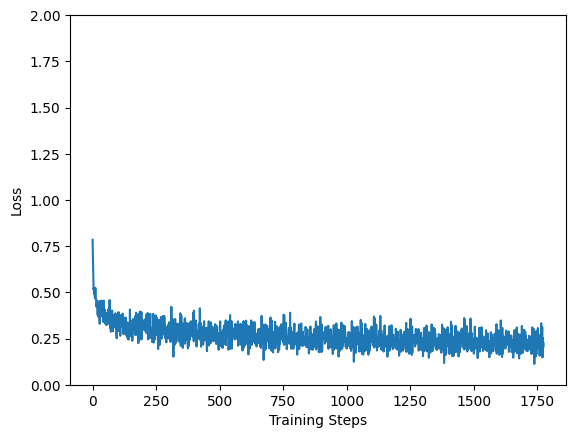

In [39]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

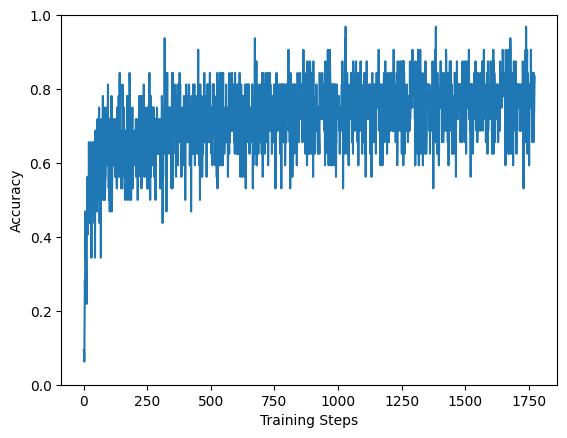

In [40]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

To redo the plot from before, first get the ordered list of class names:



In [41]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]


1/1 [==============================] - 1s 697ms/step


Plot the result

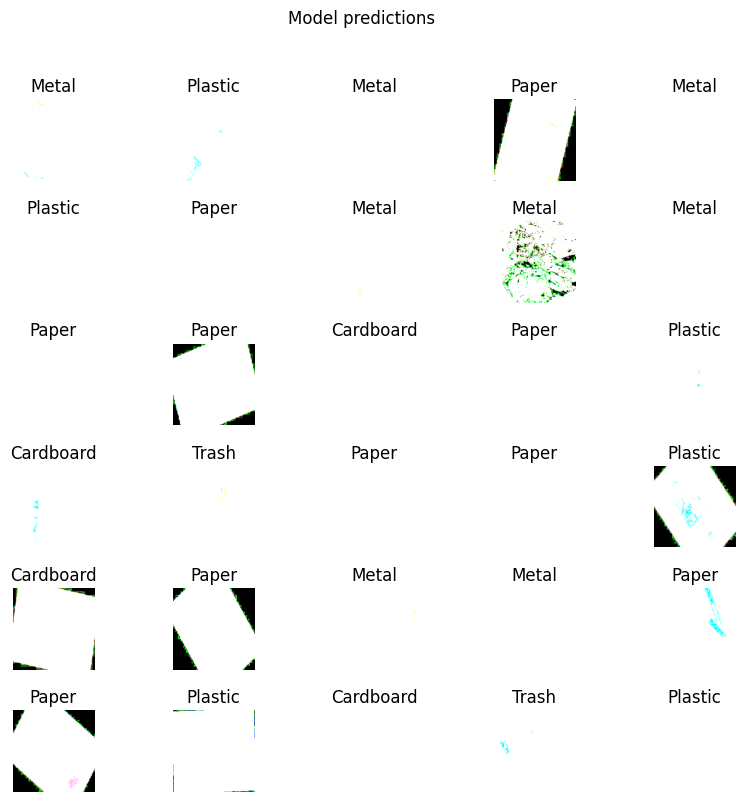

In [42]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")


## Save the Model

In [44]:
t = time.time()

export_path = "saved_models/MobileNetV2"
model.save(export_path)

export_path

'saved_models/MobileNetV2'

In [49]:
!zip -r saved_models/MobileNetV2.zip saved_models/MobileNetV2


  adding: saved_models/MobileNetV2/ (stored 0%)
  adding: saved_models/MobileNetV2/fingerprint.pb (stored 0%)
  adding: saved_models/MobileNetV2/assets/ (stored 0%)
  adding: saved_models/MobileNetV2/saved_model.pb (deflated 92%)
  adding: saved_models/MobileNetV2/variables/ (stored 0%)
  adding: saved_models/MobileNetV2/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_models/MobileNetV2/variables/variables.index (deflated 78%)
  adding: saved_models/MobileNetV2/keras_metadata.pb (deflated 80%)


In [51]:
print(tf.__version__)

2.12.0
